# Get data from NOW database
The [NOW](https://nowdatabase.org) (New and Old World) database is a database of fossil mammals (The NOW Community, 2023). Using the web interface, I downloaded a list of all occurrences of the genus _Mammuthus_.

In [3]:
# read the table (tab-separated)
mammuthus_df <- read.csv("Mammuthus/now_export_locsp_public_2023-10-20T07#11#49+0000.csv", sep="\t")

In [147]:
# packages used in this notebook.
# see here if not installed: https://nero-docs.stanford.edu/jupyter-installing-r-packages.html
library(dplyr)
library(ggplot2)
library(maps)
library(mapproj)
library(deeptime)

In [14]:
print(paste("The table has", nrow(mammuthus_df), "entries"))
print("column names are:")
colnames(mammuthus_df)

[1] "The table has 500 entries"
[1] "column names are:"


[1] "LIDNUM"                "NAME"                  "LATSTR"               
  [4] "LONGSTR"               "LAT"                   "LONG"                 
  [7] "ALTITUDE"              "MAX_AGE"               "BFA_MAX"              
 [10] "BFA_MAX_ABS"           "FRAC_MAX"              "MIN_AGE"              
 [13] "BFA_MIN"               "BFA_MIN_ABS"           "FRAC_MIN"             
 [16] "CHRON"                 "AGE_COMM"              "BASIN"                
 [19] "SUBBASIN"              "COUNTRY"               "STATE"                
 [22] "COUNTY"                "APNUMSPM"              "GENERAL"              
 [25] "LOC_SYNONYMS"          "MEAN_HYPSODONTY"       "ESTIMATE_PRECIP"      
 [28] "ESTIMATE_TEMP"         "ESTIMATE_NPP"          "PERS_WOODY_COVER"     
 [31] "PERS_POLLEN_AP"        "PERS_POLLEN_NAP"       "PERS_POLLEN_OTHER"    
 [34] "SIDNUM"                "ORDER"                 "FAMILY"               
 [37] "GENUS"                 "SPECIES"               "SUBCLASSORSUPERORDER" 
 [40] "SUBORDERORSUPERFAMILY" "SUBFAMILY"             "UNIQUE"               
 [43] "TAXON_STATUS"          "ID_STATUS"             "ADD_INFO"             
 [46] "SOURCE_NAME"           "LS_MICROWEAR"          "LS_MESOWEAR"          
 [49] "LS_MESOWEAR_SCORE"     "LS_MW_OR_HIGH"         "LS_MW_OR_LOW"         
 [52] "LS_MW_CS_SHARP"        "LS_MW_CS_ROUND"        "LS_MW_CS_BLUNT"       
 [55] "SVLENGTH"              "BODYMASS"              "SXDIMSZE"             
 [58] "SXDIMDIS"              "TSHM"                  "TCRWNHT"              
 [61] "HORIZODONTY"           "CROWNTYP"              "CUSP_SHAPE"           
 [64] "CUSP_COUNT_BUCCAL"     "CUSP_COUNT_LINGUAL"    "LOPH_COUNT_LON"       
 [67] "LOPH_COUNT_TRS"        "FCT_AL"                "FCT_OL"               
 [70] "FCT_SF"                "FCT_OT"                "FCT_CM"               
 [73] "MICROWEAR"             "MESOWEAR"              "MESOWEAR_SCORE"       
 [76] "MW_OR_HIGH"            "MW_OR_LOW"             "MW_CS_SHARP"          
 [79] "MW_CS_ROUND"           "MW_CS_BLUNT"           "DIET_1"               
 [82] "DIET_2"                "DIET_3"                "LOCOMO1"              
 [85] "LOCOMO2"               "LOCOMO3"               "SPCOMMENT"            
 [88] "SP_SYNONYM"            "SP_SYNONYM_COMMENT"    "HOMININ_BONES"        
 [91] "BIPEDAL_FOOTPRINTS"    "CUTMARKS"              "STONE_TOOLS"          
 [94] "TECHNOLOGICAL_MODE_1"  "TECHNOLOGICAL_MODE_2"  "TECHNOLOGICAL_MODE_3" 
 [97] "CULTURAL_STAGE_1"      "CULTURAL_STAGE_2"      "CULTURAL_STAGE_3"     
[100] "REGIONAL_CULTURE_1"    "REGIONAL_CULTURE_2"    "REGIONAL_CULTURE_3"

## Cleanup and enhance the data
I will only keep rows with complete data for Genus, Species, Country, Latitude and Longitude, min age and max age. 
Note that min age and max age are derived from species.

In [128]:
mammuthus_clean <- mammuthus_df %>% 
   select(GENUS, SPECIES, COUNTRY, LAT, LONG, MAX_AGE, MIN_AGE) %>%
   mutate(SPECIES = na_if(SPECIES, "indet.")) %>%  # drop rows without species
   filter(!is.na(GENUS) & !is.na(SPECIES) & !is.na(LAT) & !is.na(LONG))   

Add a column for epoch, based on max age. Epoch names are obtained from the list of epochs in the package deeptime.

In [191]:
getEpochName <- function(MAX_AGE) {
    return(filter(epochs, MAX_AGE < max_age)[1,]$name)
}
mammuthus_clean["epoch"] <- mammuthus_clean %>% select(MAX_AGE) %>% apply(1, getEpochName)

## Plotting European mammuth species on a map
I will use the maps package to plot the mammuth sites, by species and epoch, on a map of Europe.  

In [144]:
# load a line map
world_df <- map_data("world")
# bounding box for Europe
LAT1 = 70 ; LAT2 = 34
LON1 = -12 ; LON2 = 50
# plot mammuth sites on the map using geom_plot, plot map using geom_path
map <- ggplot(mammuthus_clean) +
   # plot mammuth sites as points
   geom_point(aes(LONG, LAT, color=SPECIES, shape=epoch)) +
   # plot map
   geom_path(aes(x=long, y=lat, group=group), data=world_df) +
   # Europe bounding box, mind the order of LONs and LATs
   xlim(c(LON1, LON2)) + ylim(c(LAT2, LAT1)) +
   theme_bw() + labs(title="European mammoth sites by species and epoch", x="Longitude", y="Latitude") +
   # set legend titles
   scale_shape_discrete("Epoch") + scale_color_discrete("Species")

I used the Mollweide projection, which is an elliptical projection, i.e. meridians are ellipses. A [list of supported projections is here](https://cran.r-project.org/web/packages/mapproj/mapproj.pdf).

Warning message:
“Removed 183 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 82069 rows containing missing values (`geom_path()`).”


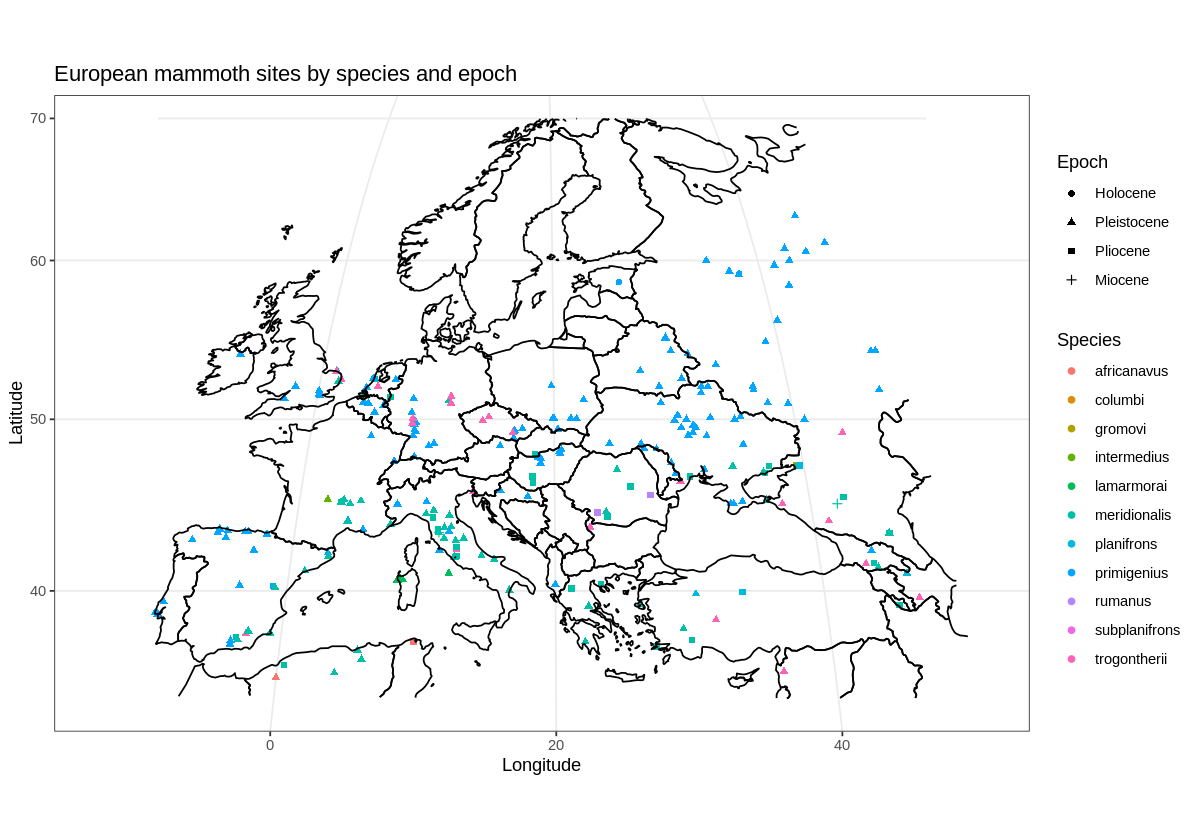

In [194]:
# compute a map projection
proj <- coord_map(
    projection="mollweide"
)

library(repr)
options(repr.plot.width=10)

# display
map + proj


The map shows that most sites throughout the map area date from teh Pleistocene, additionally there are a number of Pliocene sites in southern Europe, and one Miocene site in the Caucasus. There is even a site in Estonia dating from the Holocene (< 11kY), that's very recent for a mammoth. Let's examine these Holocene sites:

In [193]:
mammuthus_clean %>% filter(epoch=="Holocene") %>% arrange(MIN_AGE)

GENUS,SPECIES,COUNTRY,LAT,LONG,MAX_AGE,MIN_AGE,epoch
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Mammuthus,primigenius,Russia,74.50,112.00,0.00992,0.00325,Holocene
Mammuthus,primigenius,Russia,71.25,179.66,0.00440,0.00373,Holocene
Mammuthus,primigenius,Russia,59.13,37.90,0.00984,0.00976,Holocene
Mammuthus,primigenius,Russia,75.00,100.00,0.01000,0.01000,Holocene
Mammuthus,primigenius,Russia,73.60,101.13,0.01000,0.01000,Holocene
Mammuthus,primigenius,Russia,70.00,68.30,0.01035,0.01035,Holocene
Mammuthus,primigenius,Russia,71.00,68.50,0.01042,0.01042,Holocene
Mammuthus,primigenius,Russia,65.00,66.50,0.01046,0.01046,Holocene
Mammuthus,primigenius,Estonia,58.58,26.28,0.01100,0.01100,Holocene


It appears that the last mammoths mainly lived in Russia about 10.000 BP.

## References

The NOW Community 2023. New and Old Worlds Database of Fossil Mammals (NOW). Licensed under CC BY 4.0. Retrieved [20. October 2023] from https://nowdatabase.org/now/database/.
DOI 10.5281/zenodo.4268068. 